# Importing Libraries and Defining the Graph

In [231]:
import numpy as np
import networkx as nx

from pyquil import Program
from pyquil.paulis import *
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.latex import display
from pyquil.latex import to_latex

from scipy.optimize import minimize
import matplotlib
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [232]:
num_cities = 3

distance_matrix = np.matrix([[0.0, 3.0, 5.0],
 [3.0, 0.0, 4.0],
 [5.0, 4.0, 0.0]
 ])

p = 5

weight1 = 200
weight2 = 90


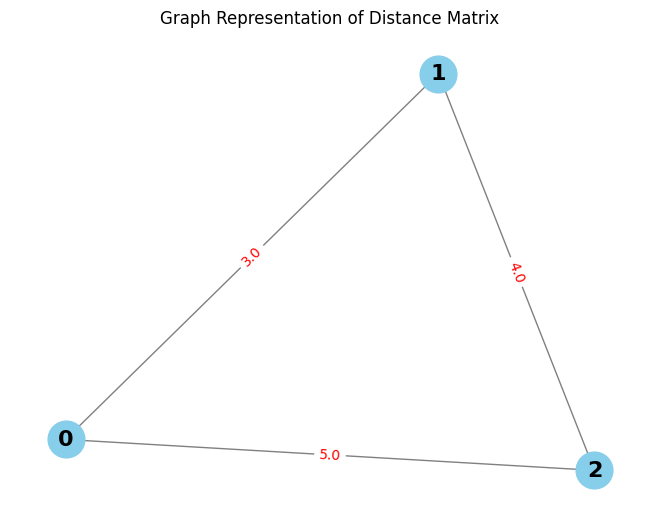

In [233]:
def visualize_graph(distance_matrix):
    G = nx.Graph()
    num_cities = distance_matrix.shape[0]

    # Add nodes
    for i in range(num_cities):
        G.add_node(i)

    # Add edges with weights
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            if distance_matrix[i, j] > 0:
                G.add_edge(i, j, weight=distance_matrix[i, j])

    pos = nx.spring_layout(G)  # positions for all nodes
    labels = nx.get_edge_attributes(G, 'weight')

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=16, font_weight='bold', edge_color='grey')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

    plt.title("Graph Representation of Distance Matrix")
    plt.show()

visualize_graph(distance_matrix)


# Defining functions 
### For preparing states, penalising invalid bitstrings, cost function

In [234]:
sim = WavefunctionSimulator()

In [235]:
def prepare_initial_state():
    pq = Program()
    # Hadamard gates applied on n^2 qubits
    for i in range(0, num_cities**2):
        pq += Program(H(i))
    return pq

### 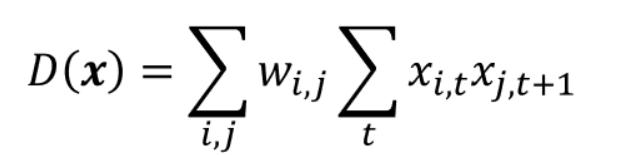

In [236]:
def penalize_distances():
	ps = sI() # Initialising an the Pauli Identity Operator
	for i in range(0, num_cities):
		for j in range(i, num_cities): # j ranges from i to num_cities to avoid double-counting
			for t in range(0, num_cities - 1): # @time steps t, all valid timesteps are considered
				wij =  - (distance_matrix.item((i, j))) / 2 # distance based weight
				q1 = (t) * num_cities + i # index (in bitstring) of the ith city at the (t)'th timestep
				q2 = (t) * num_cities + j # index (in bitstring) of the jth city at the (t)'th timestep
				ps += (wij * sI() - wij * sZ(q1) * sZ(q2)) # adds a term to the hamiltonian ps and includes a constant term and an interaction term
	print("penalize_distances() hamiltonian ", ps)
	return ps 

def penalize_multiple_locations():
	ps = sI()
	for t in range(num_cities): # penalising if more than 1 city is visited at the same timestep
		binary_representation = list(range(t * num_cities, (t + 1) * num_cities))
		ps += penalize_range(binary_representation)
	return ps

def penalize_repeated_locations():
	ps = sI()
	for i in range(num_cities): # penalising if the same city is visited more than once
		occurances_of_i = list(range(i, num_cities**2, num_cities))
		ps += penalize_range(occurances_of_i)
	return ps

def penalize_range(must_be_single_one: list):
	print("Must have a single 1: {}".format(must_be_single_one))
	i_terms = sI() #  i_terms ensures there's some base energy.
	z_terms = sI() # z_terms ensures that the penalty depends on the state of the qubits
	mixed_terms = sI() # mixed_terms ensures that the energy is minimized when exactly one qubit is in state |1>
	for qubit in must_be_single_one:
		i_terms = i_terms * sI(qubit)
		z_terms = z_terms * sZ(qubit)
		mixed_terms = mixed_terms * (sI(qubit) - sZ(qubit))
	punishment = weight1 * (i_terms + z_terms) + weight2 * mixed_terms

	return punishment


def prepare_cost():
	return penalize_distances() + penalize_repeated_locations() + penalize_multiple_locations()


# QAOA

In [237]:
# PauliSum Exponentiation from https://github.com/rigetti/pyquil/commit/785a5a549ce45da054369351032fb9ec826fdf70
def prepare_exponential(ps: PauliSum):
	fns = [exponential_map(term) for term in ps] # returns functions that, when called with a parameter, returns the exponentiation of the Pauli terms
	def exp(param): #  calls each function in fns with param and sums the resulting Program objects
		return sum([f(param) for f in fns], Program())
	return exp

def parameterized_quantum_state(h_cost, h_driver, gammas, betas):
	pq = prepare_initial_state()
	for t in range(p): # prepares and adds exponential of cost & driver Hamiltonians to pq
		pq += (prepare_exponential(h_cost))(gammas[t])
		pq += (prepare_exponential(h_driver))(betas[t])
	circuit = pq
	return pq


In [238]:

def prepare_driver(): # prepares driver hamiltonian
	ps = sI(0)
	for i in range(num_cities**2):
		ps -= sX(i) # flips current state of qubit i ?
	return ps # In the context of QAOA for TSP, this operation acts as a driver to encourage exploration of the solution space by flipping qubit states

# Collect beta, gamma, and energy values during optimization
beta_values = []
gamma_values = []
energy_values = []

def objective(params, cost_hamiltonian, driver_hamiltonian): # calculates the objective function 
	gammas = params[0:p]
	betas = params[p:2 * p]
	parameterized_pq = parameterized_quantum_state(cost_hamiltonian, driver_hamiltonian, gammas, betas)
	expectation = sim.expectation(parameterized_pq, cost_hamiltonian) # Calculates expectation value of the cost Hamiltonian
    
	gamma_values.append(gammas[0])
	beta_values.append(betas[0])
	energy_values.append(expectation.real)	

	print("Expectation is {}".format(expectation.real))
	return expectation.real

def second(elem):
	return elem[1]

# Function call and Output

penalize_distances() hamiltonian  (-11+0j)*I + (1.5-0j)*Z0*Z1 + (1.5-0j)*Z3*Z4 + (2.5-0j)*Z0*Z2 + (2.5-0j)*Z3*Z5 + (2-0j)*Z1*Z2 + (2-0j)*Z4*Z5
Must have a single 1: [0, 3, 6]
Must have a single 1: [1, 4, 7]
Must have a single 1: [2, 5, 8]
Must have a single 1: [0, 1, 2]
Must have a single 1: [3, 4, 5]
Must have a single 1: [6, 7, 8]
Expectation is 1717.4413328472158
Expectation is 1732.5198094152604
Expectation is 1772.8013581105247
Expectation is 1700.2070443850866
Expectation is 1742.7962552804645
Expectation is 1709.987760188767
Expectation is 1711.6338156510774
Expectation is 1684.9974868503919
Expectation is 1711.672601921298
Expectation is 1638.4799391260228
Expectation is 1777.896420328478
Expectation is 1729.567587159844
Expectation is 1665.8435087190526
Expectation is 1663.9373564795603
Expectation is 1865.5257738170644
Expectation is 1764.8285357506347
Expectation is 1713.9549489439662
Expectation is 1543.5377445971444
Expectation is 2001.843714591928
Expectation is 1711.8409

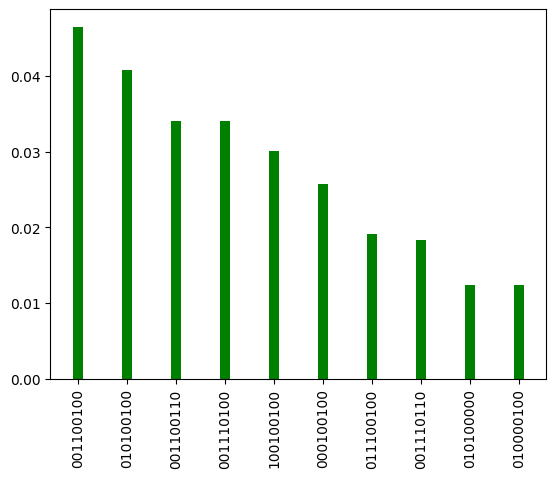

Quantum Circuit:
\documentclass[convert={density=300,outext=.png}]{standalone}
\usepackage[margin=1in]{geometry}
\usepackage{tikz}
\usetikzlibrary{quantikz}
\begin{document}
\begin{tikzcd}
\lstick{\ket{q_{0}}} & \gate{H} & \gate{X} & \gate{PHASE(-8747.364113961288)} & \gate{X} & \gate{PHASE(-8747.364113961288)} & \ctrl{1} & \qw & \ctrl{1} & \ctrl{2} & \qw & \ctrl{2} & \qw & \qw & \qw & \ctrl{3} & \qw & \qw & \qw & \ctrl{3} & \gate{R_z(-1819.2091744806837)} & \qw & \qw & \qw & \ctrl{6} & \qw & \ctrl{6} & \ctrl{3} & \qw & \ctrl{3} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{1} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{X} & \gate{PHASE(-4.703520318522928)} & \gate{X} & \gate{PHASE(-4.703520318522928)} & \gate{H} & \gate{R_z(-9.407040637045856)} & \gate{H} & \gate{X} & \gate{PHASE(-9255.97760561433)} & \gate{X} & \gate{PHASE(-9255.97760561433)} & \ctrl{1} & \

In [239]:
def solve_qaoa():
	initial_params = np.random.uniform(0.0, 2*np.pi, size=2*p)
	hamiltonians = (prepare_cost(), prepare_driver())
	optimal = minimize(objective, initial_params, hamiltonians, method='Nelder-Mead')
	angles = optimal.x
	gammas = angles[0:p]
	betas = angles[p:2*p]
	soln = parameterized_quantum_state(*hamiltonians, gammas, betas)
	prob_dict = sim.wavefunction(soln).get_outcome_probs()
	sorted_strings = []
	sorted_counts = []
	for key, value in sorted(prob_dict.items(), key=second, reverse=True):
		sorted_strings.append(key)
		sorted_counts.append(value)
	length = len(sorted_strings)
	if length > 10:
		length = 10
		sorted_strings = sorted_strings[:10]
		sorted_counts = sorted_counts[:10]
	width = 2/length
	plt.bar(sorted_strings, sorted_counts, width, color='g')
	plt.xticks(rotation=90)
	print(sorted_strings)
	print(sorted_counts)
	plt.show()
	
	parameterized_pq = parameterized_quantum_state(*hamiltonians, initial_params[0:p], initial_params[p:2*p])

	# Print the quantum circuit
	print("Quantum Circuit:")
	print(to_latex(parameterized_pq))
	print(parameterized_pq)

solve_qaoa()

1198 1198 1198
[4.703520318522928, 4.703520318522928, 4.703520318522928, 4.703520318522928, 4.703520318522928, 4.938696334449075, 4.703520318522928, 4.703520318522928, 4.703520318522928, 4.762314322504464, 4.791711324495232, 4.777012823499847, 4.795385949744077, 4.726486726328217, 4.805720833256457, 4.72907044720631, 4.74440052441634, 4.77885013612427, 4.732917320513696, 4.732917320513696, 4.850505328476769, 4.732917320513696, 4.732917320513696, 4.732917320513696, 4.784017577880462, 4.796792642222151, 4.812761472649267, 4.83272251068316, 4.882625105767893, 4.7106887982716845, 4.745642930822956, 4.817104203933765, 4.849634128691427, 4.762096522558129, 4.7770847770669675, 4.791865675933355, 4.805786323403716, 4.797409516620645, 4.797518416593812, 4.7891827207530575, 4.808370044281811, 4.822741991666214, 4.824913357308462, 4.814757576452656, 4.804903643875064, 4.813654227041841, 4.826092211430209, 4.804580190323036, 4.818921537727818, 4.797090415847231, 4.817957621943155, 4.84001477770016

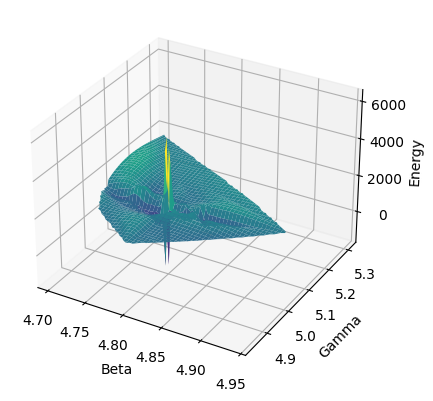

In [240]:
# Plot the data
print(len(beta_values), len(gamma_values), len(energy_values))
print(beta_values)
print(gamma_values)
print(energy_values)

beta_grid, gamma_grid = np.meshgrid(np.linspace(min(beta_values), max(beta_values), 100),
                                     np.linspace(min(gamma_values), max(gamma_values), 100))

# Interpolate the energy values onto the grid
energy_surface = griddata((beta_values, gamma_values), energy_values, (beta_grid, gamma_grid), method='cubic')

# Plot the smooth surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(beta_grid, gamma_grid, energy_surface, cmap='viridis')
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Energy')
plt.show()